# IMDB

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.text import *

In [ ]:
torch.cuda.set_device(2)

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/export.pkl')]

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [ ]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxfld 1 xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxfld 1 xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj",positive
"xxbos xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxfld 1 xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data.train_ds[0][0]

Text xxbos xxfld 1 xxmaj matthew mcconaughey is a mysterious man waiting for xxmaj agent xxmaj wesley xxmaj doyle ( xxmaj powers xxmaj boothe ) in his xxup fbi office . xxmaj he claims to have information about a serial killer chased by xxup fbi . xxmaj when xxmaj agent xxmaj doyle arrives in the office , he tells him that the serial killer is indeed his dead brother . xxmaj agent xxmaj doyle xxunk some evidence , and the man tells the story of his life , since his childhood . xxmaj they were a simple family of three : his widow father xxmaj xxunk ( xxmaj bill xxmaj paxton ) , his brother and himself . xxmaj one night , his father xxunk the two brothers and tells them that an angel of xxmaj god had just visited him and assigned his family to destroy demons . xxmaj what happens next is one of the most scary movie i have ever seen . 

 i watched this movie four months ago on xxup vhs , and yesterday i watched again , now on xxup dvd . xxmaj although being a low - budget movie , the scree

But the underlying data is all numbers

In [ ]:
data.train_ds[0][0].data[:10]

array([   2,    3,   45,    4, 3229, 3805,   15,   12, 1232,  132])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
bs=48

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj in a xxmaj woman xxmaj under the xxmaj influence xxmaj mabel goes crazy , but i can see why she does go crazy . xxmaj if i lived the kind of life she lived with the family she has i would go crazy too . xxmaj everyone in her family is off their rocker and not completely with it . xxmaj she is constantly surrounded by people yelling"
1,", fresh from success as xxmaj elliot 's mom in "" xxup e.t - xxmaj the xxmaj extra xxmaj terrestrial "" ) is a mother whose marriage to husband xxmaj vic ( xxmaj daniel xxmaj hugh - xxmaj kelly ) is hanging by a thread . xxmaj she 's been having an affair with a local worker , and is now dwelling on whether or not to leave her husband"
2,". xxbos xxmaj the reason why this movie sucks , have these people even read a bible ? xxmaj everything in the movie was about moses , xxmaj god was staying out of it . xxup that xxup didn't xxup happen ! xxmaj god directed everything , he told them where to go and what to do . xxmaj also the people wandered for 40 years xxup after they arrived"
3,"to sleep . xxbos a little bit of a let down . xxmaj personal opinion , this was a movie with much more potential that was never allowed to reach that . xxmaj sean xxmaj patrick xxmaj flanery has good moments in the movie , but as a whole his performance does n't come close to some of his other movies like xxmaj powder and xxmaj boondock xxmaj saints ."
4,"purity that it will remind you of the work of some of the great masters of the past . xxmaj the regard for its audience is something that we 're not used to anymore . i do n't know if we ever were . xxmaj riveting , moving , without concessions and xxmaj benicio del xxmaj toro is just extraordinary . xxmaj we can see his soul , we can"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


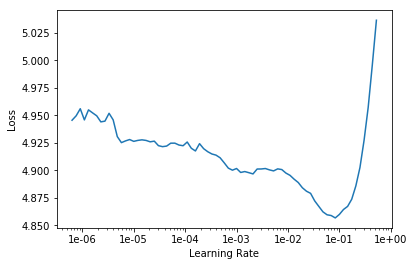

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.206495,4.067840,0.292376


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.949835,3.892163,0.309857
2,3.863976,3.823716,0.319508
3,3.827637,3.776987,0.325163
4,3.782025,3.738658,0.329756
5,3.704519,3.705750,0.333159
6,3.658038,3.682820,0.335856
7,3.608049,3.662626,0.338366
8,3.552923,3.648938,0.340119
9,3.518708,3.642814,0.340864
10,3.480421,3.641818,0.340905


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was clearly a movie . xxmaj so i gave it a 2 out of 10 . xxmaj so , just say something . xxbos xxmaj this is a really stunning picture , light years off of the late xxmaj
i liked this movie because it would be a good one for those who like deep psychological and drama and you can go see this movie if you like a little slow motion and some magic should n't be there . i would give it


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised xxunk :- xxmaj the xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff """,neg
"xxbos xxunk ) is the developing world 's answer to xxmaj silence of the xxmaj lambs . xxmaj where ` xxmaj silence ' terrorized our peace of mind , ` xxmaj citizen ' exhausts and saddens us instead . xxmaj this dramatization of the xxmaj chikatilo case translates rather well , thanks to a xxmaj westernized friendship between two xxmaj rostov cops who become equals . \n\n citizenx may also",pos
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
gc.collect();

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


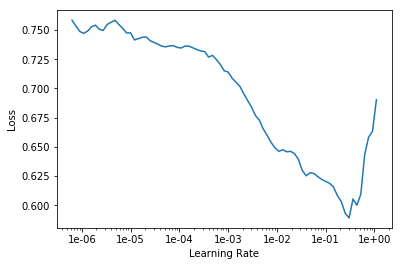

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:46
epoch  train_loss  valid_loss  accuracy
1      0.294225    0.210385    0.918960  (02:46)



In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.507567,0.344481,0.855000


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:03
epoch  train_loss  valid_loss  accuracy
1      0.268781    0.180993    0.930760  (03:03)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:06
epoch  train_loss  valid_loss  accuracy
1      0.211133    0.161494    0.941280  (04:06)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 10:01
epoch  train_loss  valid_loss  accuracy
1      0.188145    0.155038    0.942480  (05:00)
2      0.159475    0.153531    0.944040  (05:01)



In [ ]:
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(0), tensor([[9.9999e-01, 1.1991e-05]]))